In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from utils import load_dataset, imshow, get_train_split_sizes, set_parameter_requires_grad
from training import train_model, visualize_model, test
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
DS_PATH = './dataset'

In [5]:
train_dir = os.path.join(DS_PATH, 'train')
test_dir = os.path.join(DS_PATH, 'TestR')

In [7]:
BATCH_SIZE = 1024
IMG_SIZE = (64, 64)

In [8]:
TRAIN_EPOCHS = 25
FINETUNE_EPOCHS = 10

In [9]:
class_no = 43
VAL_SIZE = 0.2

In [10]:
gpu = torch.cuda.is_available()

In [11]:
dataloaders, image_datasets = load_dataset(IMG_SIZE, train_dir, test_dir,
                                           batch_size=BATCH_SIZE, val_size=VAL_SIZE, 
                                           pin_memory=gpu)
train_size, val_size = get_train_split_sizes(image_datasets, VAL_SIZE)

dataset_sizes = {
    'test': len(image_datasets['test']),
    'train': train_size,
    'val': val_size
                }
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if gpu else "cpu")

In [12]:
print(f'Dataset sizes: {dataset_sizes}')

Dataset sizes: {'test': 12630, 'train': 73153, 'val': 18288}


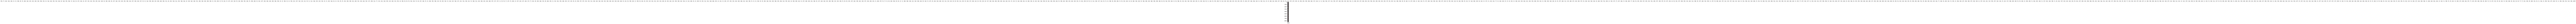

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [98]:
im_orig = Image.open('./dataset/train/0/00000_00000_00000.png')
# Remove the mean
im = transforms.Compose([
     transforms.ToTensor()
    ])(im_orig)
img = torch.tensor(im[None,:,:,:],requires_grad =True)

/tmp/ipykernel_8375/421686587.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(im[None,:,:,:],requires_grad =True)


## Training

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
def deepfool(image, net, num_classes=43, overshoot=0.02, 
             max_iter=10, target=13):

    f_image = net.forward(image).data.numpy().flatten()
    
    target_g = np.array(f_image).flatten()[target]
    # to sortuje po najbardziej prawdopodobnych klasach
    I = (np.array(f_image)).flatten().argsort()[::-1]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    # to są policzone gradienty
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]

    k_i = I[0]

    while k_i != target and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()
        # x.zero_grad()

        fs[0, target].backward(retain_graph=True)
        cur_grad = x.grad.data.numpy().copy()

        # set new w_k and new f_k
        w_k = cur_grad - grad_orig
        f_k = (fs[0, target] - fs[0, I[0]]).data.numpy()
        w=w_k
        
        # compute r_i and r_tot
#         # Added 1e-4 for numerical stability
        r_i =  (abs(f_k) + 1e-4) * w_k / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, k_i==target

In [120]:
a, f = deepfool(img, model_ft)

/tmp/ipykernel_8375/2679149432.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image[None, :],requires_grad=True)
/tmp/ipykernel_8375/2679149432.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image, requires_grad=True)


In [121]:
a = a[0][0]

In [108]:
# pert_image_numpy = a.detach().squeeze().numpy()
# print(pert_image_numpy.shape)
plt.figure()
plt.imshow(pert_image_numpy.transpose(1,2,0))
plt.title(str_label_pert)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [125]:
a.shape

(30, 29, 3)

In [124]:
a = a.transpose(1,2,0)

In [127]:
Image.fromarray(a, 'RGB')